# Objective

* properly format location, title, requirements
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement

Stretch goals
* add input to allow users to specifiy the cities to look at

* add a map to visualize how many postings there are in each city 

# Source:
https://www.kaggle.com/residentmario/exploring-monster-com-job-postings/data

In [1]:
import numpy as np
import pandas as pd

In [5]:
jobs = pd.read_csv("monster_com-job_sample.csv")

In [6]:
# Clean up the fields a bit
jobs = (jobs.drop(["job_board", "has_expired", "country", "country_code", "uniq_id"],
                  axis='columns'))

In [8]:
jobs = jobs[jobs['location'].str.len() < 40]

def map_yearly_salary_range(val):
    if pd.isnull(val):
        return np.nan
    elif "/year" in val:
        part = val.split("/year")[0].replace("$", " ").strip()
        if "-" in part:
            mn, mx = part.split("-")[0:2]
            try:
                mn = float(mn.replace(",", "").strip())
                mx = float(mx.replace(",", "").strip())
            except:
                return np.nan
            return mn, mx

def map_hourly_salary_range(val):
    if pd.isnull(val):
        return np.nan
    elif "/hour" in val:
        part = val.split("/hour")[0].replace("$", " ").strip()
        if "-" in part:
            mn, mx = part.split("-")[0:2]
            try:
                mn = float(mn.replace(",", "").strip())
                mx = float(mx.replace(",", "").strip())
            except:
                return np.nan
            return mn, mx
        
jobs = jobs.assign(yearly_salary_range=jobs['salary'].map(map_yearly_salary_range),
                   hourly_salary_range=jobs['salary'].map(map_hourly_salary_range))

print("We found {0} yearly and {1} hourly salaries in the dataset.".format(
    jobs['yearly_salary_range'].notnull().sum(), jobs['hourly_salary_range'].notnull().sum()
))

We found 1653 yearly and 1048 hourly salaries in the dataset.


In [9]:
jobs['job_type'] = jobs['job_type'].map(
    lambda j: j if pd.isnull(j) else 'Full Time' if 'Full Time' in j else 'Part Time' if 'Part Time' in j else 'Other'
)

# Types and sectors of jobs listed in Monster.com

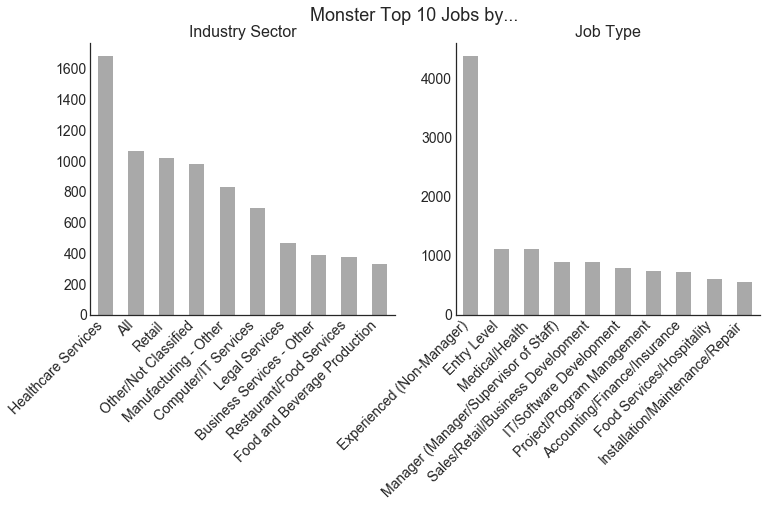

In [12]:
# Creating the plot.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

f, axarr = plt.subplots(1, 2, figsize=(12, 5))
f.subplots_adjust(hspace=1)
plt.suptitle('Monster Top 10 Jobs by...', fontsize=18)

bar_kwargs = {'fontsize': 14, 'color': 'darkgray'}

jobs['organization'].value_counts().head(10).plot.bar(ax=axarr[0], **bar_kwargs,
                                                      title='Industry Sector')
jobs['sector'].value_counts().head(10).plot.bar(ax=axarr[1], **bar_kwargs,
                                                         title='Job Type')

sns.despine()

for n in [0, 1]:
    axarr[n].title.set_fontsize(16)
    axarr[n].set_xticklabels(axarr[n].get_xticklabels(), 
                             rotation=45, ha='right', fontsize=14)
plt.show()

# Median Salaries

C:\Users\mhuh22\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\mhuh22\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


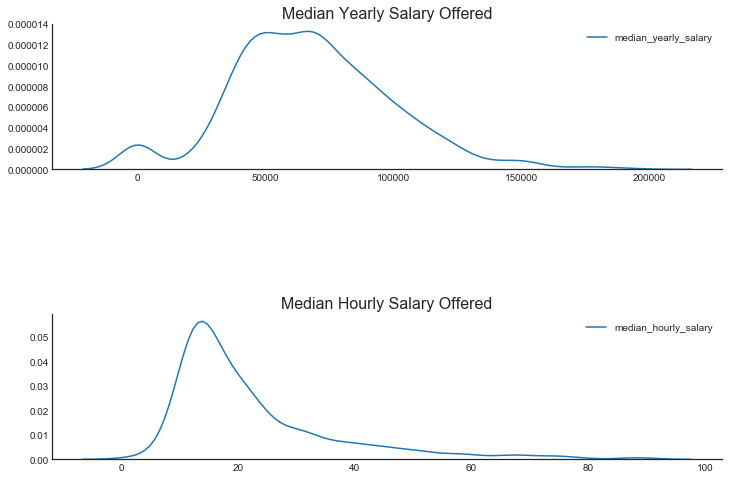

In [14]:
f, axarr = plt.subplots(2, 1, figsize=(12, 8))
f.subplots_adjust(hspace=1)

bar_kwargs = {'fontsize': 14, 'color': 'darkgray'}

jobs = jobs.assign(
    median_yearly_salary = jobs['yearly_salary_range'].map(
        lambda r: (r[0] + r[1]) / 2 if pd.notnull(r) else r
    ),
    median_hourly_salary = jobs['hourly_salary_range'].map(
        lambda r: (r[0] + r[1]) / 2 if pd.notnull(r) else r
    )
)

sns.kdeplot(jobs[pd.notnull(jobs.median_yearly_salary)]['median_yearly_salary']\
                .where(lambda v: v < 200000), 
            ax=axarr[0]
)
sns.kdeplot(jobs[pd.notnull(jobs.hourly_salary_range)]['median_hourly_salary']\
                .where(lambda v: v < 100), 
            ax=axarr[1]
)

axarr[0].set_title("Median Yearly Salary Offered", fontsize=16)
axarr[1].set_title("Median Hourly Salary Offered", fontsize=16)

sns.despine()

# Summarize Job Descriptions

In [16]:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from string import punctuation
from heapq import nlargest

class FrequencySummarizer:
    def __init__(self, min_cut=0.1, max_cut=0.9):
        """
         Initilize the text summarizer.
         Words that have a frequency term lower than min_cut 
         or higer than max_cut will be ignored.
        """
        self._min_cut = min_cut
        self._max_cut = max_cut 
        self._stopwords = set(stopwords.words('english') + list(punctuation))
    
    def _compute_frequencies(self, word_sent):
        """ 
        Compute the frequency of each of word.
        Input: 
           word_sent, a list of sentences already tokenized.
        Output: 
           freq, a dictionary where freq[w] is the frequency of w.
        """
        freq = defaultdict(int)
        for s in word_sent:
            for word in s:
                if word not in self._stopwords:
                    freq[word] += 1
        # frequencies normalization and fitering
        m = float(max(freq.values()))
        for w in list(freq.keys()):
            freq[w] = freq[w]/m
            if freq[w] >= self._max_cut or freq[w] <= self._min_cut:
                del freq[w]
        return freq
    
    def summarize(self, text, n):
        """
          Return a list of n sentences 
          which represent the summary of text.
        """
        sents = sent_tokenize(text)
    
        try:
            assert n <= len(sents)
        except AssertionError:
            return ""
        
        word_sent = [word_tokenize(s.lower()) for s in sents]
        self._freq = self._compute_frequencies(word_sent)
        ranking = defaultdict(int)
        for i,sent in enumerate(word_sent):
            for w in sent:
                if w in self._freq:
                    ranking[i] += self._freq[w]
        sents_idx = self._rank(ranking, n)    
        return [sents[j] for j in sents_idx]

    def _rank(self, ranking, n):
        """ return the first n sentences with highest ranking """
        return nlargest(n, ranking, key=ranking.get)

In [19]:
" ".join(FrequencySummarizer().summarize(
    jobs.iloc[0].job_description.replace(".", ". ").replace("•", " "), 2)
)

"TeamSoft has been in business since 1996  TeamSoft's owners are local IT professionals who possess a wealth of experience in application development, business analysis, and project management  TeamSoft's Recruiters are knowledgeable, friendly, and ready to help you make your next great career move  TeamSoft offers a full benefits suite to all of our W2 consultants, including a 401k plan with a 100% vested 4% dollar for dollar match  Our targeted selection process is designed to get to know your strengths and career interests and provide you with the best chance for success in your new position  Our longest running consultant has been with us for 16 years  Consultants can participate in our charitable giving committee. Required Skills:  Call tracking software  Phone based technical support  Problem documentation and communication  Remote Desktop Management Tools  Respond to customer requests  General understanding of LANDesk  Microsoft Office 2007 SuiteFind out why TeamSoft is the Madi

In [21]:
stops = set(stopwords.words('english') + list(punctuation))

In [22]:
summary_words = jobs.head(1000).job_description.map(lambda desc: set(
    word_tokenize(
        " ".join(
            FrequencySummarizer().summarize(desc.replace(".", ". ").replace("•", " "), 2)
        )
    )
) - stops
                                                     )
import itertools
# non_summary = pd.Series(list(itertools.chain.from_iterable(non_summary_words.values)))
summary = pd.Series(list(itertools.chain.from_iterable(summary_words.values)))

Text(0.5,0.98,'Top 10 Most Occurent Important Words in Job Descriptions')

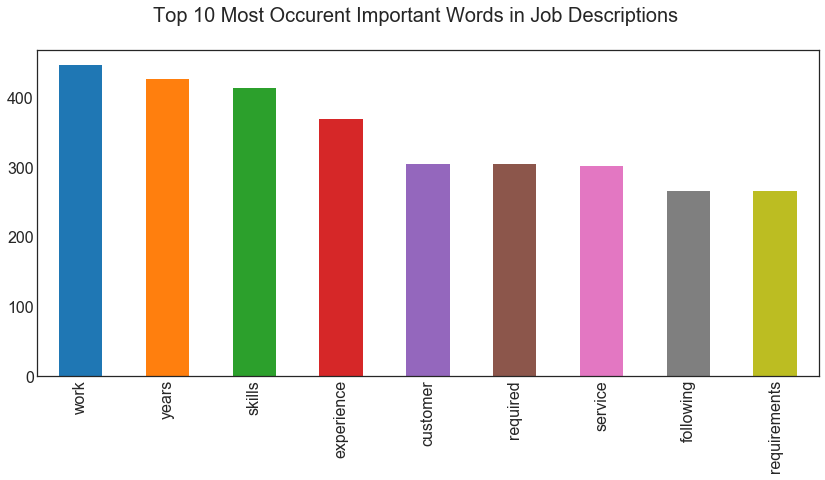

In [23]:
import seaborn as sns
sns.set_style("white")

(summary
     .value_counts(ascending=False)
     .head(12)
     .drop(['Qualifications', 'meet', 'including'])
     .plot.bar(fontsize=16, figsize=(14, 6)))
plt.gcf().suptitle('Top 10 Most Occurent Important Words in Job Descriptions', fontsize=20)
